# 01_dataset_understanding.ipynb

We will use the train/test data generated from *00_create_dataset.ipynb* and do some basic data exploration

In [ ]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

In [ ]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Basic data inspection

In [ ]:
# load data
train = pd.read_csv(root_dir/"data/train.csv")
test = pd.read_csv(root_dir/"data/test.csv")
print("data loaded")

data loaded


In [ ]:
# check shape
print(train.shape)
print(test.shape)

(280145, 139)
(120504, 139)


In [ ]:
# inspect train
train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
0,1,9.821427,-0.014818,-0.019394,-0.019283,-0.000944,-0.007844,1,5.285973,3.011525,-1.393305,-0.735402,-0.908020,-0.471151,0.057697,0.018536,5.039879,2.003304,0.110838,0.059365,3.888114,1.897805,2.326891,1.192483,0.124007,0.103903,4.356158,3.063248,0.196822,0.170808,4.148956,3.256711,4.659288,3.250720,0.145466,0.169213,-0.854551,-0.568027,0.234736,0.262047,...,0.325887,0.318745,0.637013,-2.433448,0.436319,0.922601,0.425173,0.577809,0.439945,-2.204590,0.299702,1.249999,0.328022,1.205414,1.116665,-2.806147,0.439111,-0.479490,0.424391,0.172390,-0.016806,-3.116017,0.316525,0.265058,0.296737,1.135212,0.882452,-1.872665,0.462489,0.201461,4.728494,5.309723,3.199164,4.911131,4.783926,4.397508,5.122683,4.998204,5587,0
1,1,0.838150,-0.002198,-0.002562,-0.016964,-0.029155,-0.025479,1,-3.172026,-3.093182,1.068607,0.506972,1.252115,0.665742,0.057697,0.018536,-5.424993,-3.081836,0.110838,0.059365,7.689749,4.512754,0.984244,-0.016600,0.124007,0.103903,1.158439,0.607663,0.196822,0.170808,8.307519,6.775615,1.862624,1.058943,0.145466,0.169213,-3.362551,-3.193465,0.234736,0.262047,...,0.325887,5.589854,5.105871,-1.844534,0.436319,-0.412149,0.425173,1.322766,0.139397,-2.070829,0.299702,-0.027765,0.328022,11.161628,4.178262,-1.028454,0.439111,-1.133088,0.424391,0.814667,-0.193307,-3.457956,0.316525,2.775705,0.296737,10.258894,5.395499,-0.995543,0.462489,0.201461,1.998274,3.805928,3.327486,8.298933,4.331993,6.636454,2.742866,4.421242,5588,0
2,1,0.115654,0.025969,0.033227,0.026518,-0.007137,0.005205,-1,-1.995780,-2.397085,0.631661,0.260796,-0.606878,-0.318215,0.057697,0.018536,0.204725,-0.701564,0.110838,0.059365,-0.603418,-0.861179,0.439080,-0.598599,0.124007,0.103903,-0.890208,-0.646109,0.196822,0.170808,-0.886307,-0.570991,-1.106967,-0.692671,0.145466,0.169213,1.127499,0.633285,0.234736,0.262047,...,0.325887,0.884953,0.188384,-2.765658,0.436319,-0.504551,0.425173,-0.430036,-0.464120,-2.685705,0.299702,-0.459645,0.328022,0.233487,-0.397084,-2.963520,0.439111,-2.448930,0.424391,-0.544723,-1.970004,-4.225394,0.316525,-1.560801,0.296737,0.728752,-0.509478,-2.054889,0.462489,0.201461,0.571110,1.961126,0.115093,1.678828,0.269419,1.380691,0.414362,1.482215,5589,1
3,1,0.051481,0.004050,0.010332,0.011625,0.015717,0.020223,-1,-3.172026,-3.093182,0.191000,0.067753,0.518630,0.281647,0.057697,0.018536,0.441757,-0.384421,0.110838,0.059365,-0.691991,-0.850861,0.115220,-0.712472,0.124007,0.103903,-1.818579,-1.766257,0.196822,0.170808,-1.806182,-1.849151,-2.253638,-2.042811,0.145466,0.169213,1.263765,0.915293,0.234736,0.262047,...,0.325887,4.177239,6.526127,-1.006093,0.436319,-0.511856,0.425173,-0.544758,-0.690390,-2.664273,0.299702,-0.416616,0.328022,1.662032,-0.769501,-1.762745,0.439111,-0.747797,0.424391,-0.537692,-0.940779,-3.816933,0.316525,5.320100,0.296737,3.824343,4.534711,-0.976600,0.462489,0.201461,0.030937,3.310013,0.616731,6.730575,0.775897,5.260658,0.133797,3.438925,5592,1
4,1,0.401532,-0.003251,-0.007810,-0.009187,-0.016094,-0.018165,1,-1.668771,-2.172676,-0.380094,-0.234366,-0.610825,-0.366429,0.057697,0.018536,-3.193625,-1.963297,0.110838,0.059365,-2.259535,-1.622893,-2.970833,-3.263832,0.124007,0.10

In [ ]:
# inspect test
test.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
0,3,7.481076,-0.005057,-0.008262,-0.014311,-0.018114,-0.015419,1,2.663412,3.184785,-0.108482,-0.101635,0.340776,0.337564,0.057697,0.018536,1.357578,1.293543,0.110838,0.059365,1.411396,1.448887,0.562188,0.986741,0.124007,0.103903,2.068331,2.909274,0.196822,0.170808,2.485053,3.677383,2.229291,3.007236,0.145466,0.169213,-0.529661,-0.740136,0.234736,0.262047,...,0.325887,-0.027215,-0.543127,-2.913095,0.436319,0.851514,0.425173,-0.023394,0.384650,-2.356273,0.299702,1.543714,0.328022,0.531520,1.449822,-2.818499,0.439111,-0.478218,0.424391,-0.383816,-0.836964,-3.720498,0.316525,0.743319,0.296737,0.345498,0.265471,-2.057983,0.462489,0.201461,0.387822,5.054960,0.519173,7.369856,0.867638,6.399190,0.772381,5.851821,15219,0
1,3,2.541412,0.005050,0.009560,0.021086,0.029987,0.023465,1,2.231333,0.929773,-0.076187,-0.073584,-0.704473,-0.400425,0.057697,0.018536,-0.809340,-1.135182,0.110838,0.059365,-0.968611,-0.989023,-0.752374,-1.582346,0.124007,0.103903,3.045360,2.316931,0.196822,0.170808,2.405342,1.877978,3.238101,2.390879,0.145466,0.169213,-2.552519,-2.531221,0.234736,0.262047,...,0.325887,-0.617359,0.074816,-4.068894,0.436319,1.411089,0.425173,0.061512,0.818424,-2.604537,0.299702,-0.230667,0.328022,-0.985122,-0.717096,-5.136856,0.439111,2.874373,0.424391,0.570497,2.311909,-3.108549,0.316525,-0.570055,0.296737,-2.023391,-0.972688,-3.411030,0.462489,0.201461,3.095879,-0.526921,2.911567,-0.650246,3.966170,-0.564345,3.375062,-0.643761,15220,1
2,3,0.405529,0.005226,0.008275,0.010546,0.012440,0.011228,1,-0.817273,-0.204123,-0.108383,-0.109990,-0.835789,-1.189301,0.057697,0.018536,-0.912162,-0.157431,0.110838,0.059365,0.080956,0.618816,-1.046966,-1.123527,0.124007,0.103903,0.481340,1.038576,0.196822,0.170808,0.784753,1.706369,0.675991,1.359656,0.145466,0.169213,-0.106605,-0.135824,0.234736,0.262047,...,0.325887,-0.595608,-0.457747,-2.486037,0.436319,-0.026142,0.425173,-0.041383,-0.211637,-2.078765,0.299702,-0.138229,0.328022,0.080302,-0.437355,-2.753820,0.439111,-2.058798,0.424391,-0.458743,-1.757123,-2.972844,0.316525,-2.025423,0.296737,-0.489641,-1.578295,-1.878226,0.462489,0.201461,-1.055147,2.307767,-1.005259,2.467189,-1.565015,2.016626,-1.326771,1.915892,15221,1
3,3,0.492947,-0.001117,-0.000892,-0.007417,-0.013809,-0.006213,1,-3.172026,-3.093182,0.152462,0.095534,-0.778204,-0.641386,0.057697,0.018536,-2.853978,-1.845645,0.110838,0.059365,1.710502,1.294546,-2.151323,-2.709621,0.124007,0.103903,-0.113250,-0.177388,0.196822,0.170808,2.179006,2.594442,0.023130,-0.044940,0.145466,0.169213,-1.435509,-1.885774,0.234736,0.262047,...,0.325887,-0.314930,-0.080715,-2.786589,0.436319,-0.333619,0.425173,-0.627701,-0.564260,-2.965181,0.299702,-0.095864,0.328022,0.053721,-0.534112,-3.293924,0.439111,-2.463752,0.424391,-1.137310,-2.643127,-4.728830,0.316525,-1.184614,0.296737,-0.318396,-1.018013,-2.158885,0.462489,0.201461,0.257676,5.837066,1.414953,13.321513,1.831488,10.932440,1.089419,8.258604,15222,0
4,3,0.491824,0.000363,0.000379,-0.006306,-0.014401,-0.009981,1,-3.172026,-3.093182,0.117693,0.060338,-0.055102,-0.051371,0.057697,0.018536,-3.460218,-2.211427,0.110838,0.059365,2.176433,1.585178,-1.211952,-1.

In [ ]:
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values

# `train` vs `test` data
The `test` dataset is exactly the same as `train`, except the entries come from different dates so as to have no overlap with the train data. Our test dataset is a subset of our original data, because we have no access to the Jane Street test dataset since the competition has come to a close.

# Explanation of data
* `date` - Several rows have the same date. This is only used to correlate them for calculation of the score
* `weight` - can be thought of as portfolio weight for an investment
* `resp` - can be thought of as return on investment
* `resp_1` to `resp_4` - These are values that represents future returns, whereas `resp` represents the return for that specific day. They are used as additional target to assist in the training step, but not utilised during the test phase
* `feature_0` to `feature_129` - Anonymized features of the particular investment, representing our input variables in training
* `ts-id` - Ordering of the entries by time. However this is not necessary
* `action` - binary value of 1 or 0. Using `weight` and `resp`, if the product of them is positive, that indicates a profitable trade and action should be 1

# How the data will be used
* Training will be done using `feature_0` to `feature_129` as input to our models (x variables), and the target variable will be `action` (y variable)
* Note that `resp`, `resp_1` to `resp_4` can be considered for use as an alternative y-variable through np.stack() as well. This will cause the model to account for future information in its prediction.
* We will then define a function to calculate a utility score based on the competition guidelines. For a given dataset, the maximum utility score can be achieved when all the correct actions have been made for every entry

# Scoring

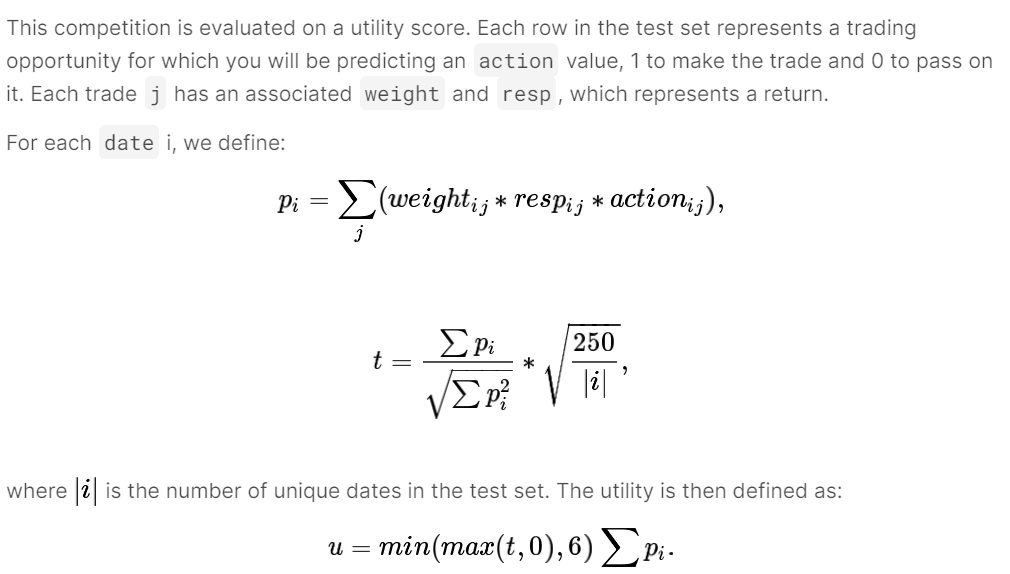

In [ ]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

We now have a function to obtain the maximum attainable utility score for both train and test. We can then benchmark model performances against these scores

In [ ]:
print("Maximum achievable score for train: ", utility_score(train, y_train))
print("Maximum achievable score for test: ", utility_score(test, y_test))

Maximum achievable score for train:  38666.152212179244
Maximum achievable score for test:  15405.02761054398


# PCA analysis 
We shall try and check for features that do not contribute much to the dataset. This is just for our understanding as we will begin by creating machine learning models that utilise all of the features available to us. However in the later stages, we can consider dropping unimportant features

https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA()

In [ ]:
features = [feature for feature in test.keys() if "feature" in feature]
x_train_pca = train.loc[:, features].values
y_train_pca = train.loc[:,['action']].values

In [ ]:
y_train_pca = StandardScaler().fit_transform(y_train_pca)
y_train_pca = pd.DataFrame(y_train_pca)
x_train_pca_transform = pca.fit_transform(x_train)
x_train_pca_transform = pd.DataFrame(x_train_pca_transform)

In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([5.96727092e-01, 9.94882694e-02, 4.28925247e-02, 3.82844932e-02,
       3.50410591e-02, 2.53552544e-02, 1.68403614e-02, 1.51200499e-02,
       1.21568513e-02, 1.06776497e-02, 1.01687412e-02, 8.29152227e-03,
       7.81683872e-03, 6.54625032e-03, 5.93675461e-03, 5.83039826e-03,
       5.56826215e-03, 4.83618093e-03, 4.17539473e-03, 3.50458218e-03,
       3.18209437e-03, 2.95928184e-03, 2.61770789e-03, 2.30452251e-03,
       2.19671375e-03, 2.00393257e-03, 1.92476467e-03, 1.72614750e-03,
       1.62718947e-03, 1.52466970e-03, 1.46023430e-03, 1.32842303e-03,
       1.27720522e-03, 1.17647319e-03, 1.03317872e-03, 9.85247539e-04,
       9.56020264e-04, 8.30965576e-04, 8.20393107e-04, 7.46392999e-04,
       7.19642599e-04, 6.95186091e-04, 6.30975415e-04, 6.23916385e-04,
       5.40366555e-04, 5.23453856e-04, 4.86701992e-04, 4.74507412e-04,
       4.42353327e-04, 4.28148351e-04, 4.11858513e-04, 3.98114360e-04,
       3.74869137e-04, 3.39526956e-04, 3.11858035e-04, 2.87627346e-04,
      